# **1. Loading & Cleaning Data**

In [148]:
import yfinance as yf

gold_ticker = yf.Ticker("GC=F")

df = gold_ticker.history(period="1y", interval='1h')

df.drop(columns=['Dividends', 'Stock Splits'], inplace=True)

display(df.head(3))
display(df.shape)

,Open,High,Low,Close,Volume
Datetime,,,,,
2023-09-18 18:00:00-04:00,1955.300049,1955.400024,1954.699951,1955.099976,0
2023-09-18 19:00:00-04:00,1955.000000,1956.000000,1954.699951,1955.599976,1307
2023-09-18 20:00:00-04:00,1955.599976,1956.000000,1954.000000,1954.099976,1760


(5773, 5)

# **Creating Constants needed**

In [149]:
WINDOW = 7

# RRR is 1 SL = TP = 1 STD
PNL = {
    'WIN': 1,
    'LOSS': -1
}

SIGNALS = {
    'BUY': 1,
    'SELL': -1
}

STD_FACTORS = {
    'ENTRY': 2.2,
    'SL': 2, # is calculated from entry
    'TP': 1 # is calculated from entry
}

# **2. Defining the Strategy (Mean Reversion)**

### We will create Columns needed

In [150]:
# Low
df['Mean_L'] = df['Low'].rolling(window=WINDOW).mean()
df['STD_L'] = df['Low'].rolling(window=WINDOW).std()
df['Z-Score_L'] = (df['Low'] - df['Mean_L']) / df['STD_L']

# High
df['Mean_H'] = df['High'].rolling(window=WINDOW).mean()
df['STD_H'] = df['High'].rolling(window=WINDOW).std()
df['Z-Score_H'] = (df['High'] - df['Mean_H']) / df['STD_H']

df.dropna(inplace=True)
df.reset_index(inplace=True)

display(df.head())

,Datetime,Open,High,Low,Close,Volume,Mean_L,STD_L,Z-Score_L,Mean_H,STD_H,Z-Score_H
0,2023-09-19 00:00:00-04:00,1953.500000,1953.900024,1952.699951,1952.699951,1641,1953.785697,0.751503,-1.444766,1955.014282,0.807111,-1.380551
1,2023-09-19 01:00:00-04:00,1952.699951,1953.099976,1951.599976,1952.199951,2910,1953.342843,0.996429,-1.749114,1954.685704,1.054245,-1.504137
2,2023-09-19 02:00:00-04:00,1952.199951,1952.599976,1951.199951,1951.800049,3825,1952.842843,1.076837,-1.525665,1954.199986,1.128423,-1.417917
3,2023-09-19 03:00:00-04:00,1951.800049,1956.199951,1951.800049,1955.800049,6692,1952.528564,1.001205,-0.727638,1954.228551,1.182802,1.666720
4,2023-09-19 04:00:00-04:00,1955.800049,1956.300049,1954.800049,1955.199951,4071,1952.757150,1.313874,1.554866,1954.457136,1.419933,1.297887


### Overview

<Axes: ylabel='Z-Score'>

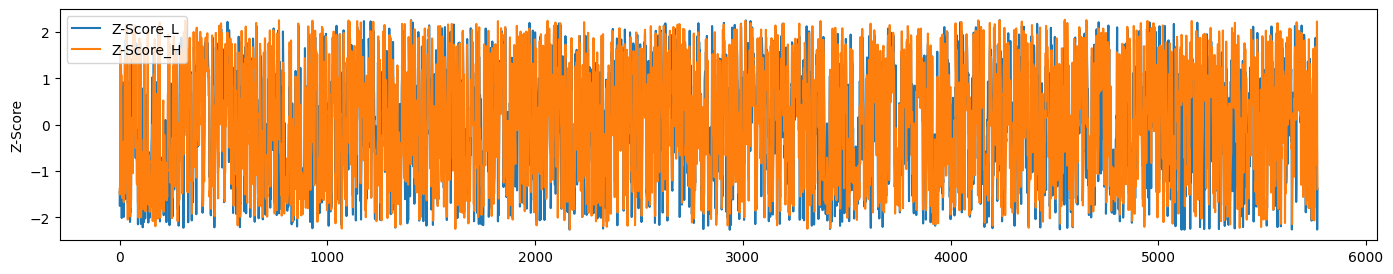

In [151]:
df[['Z-Score_L', 'Z-Score_H']].plot(kind='line', figsize=(17, 3), ylabel="Z-Score")

Z-Score_L
False    0.95717
True     0.04283
Name: proportion, dtype: float64

,Z-Score_L,Z-Score_H
max,2.258415,2.265128
min,-2.264885,-2.253621


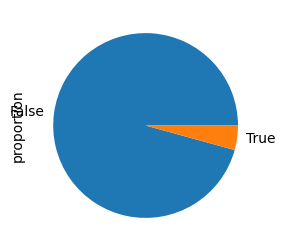

In [152]:
stats = (abs(df['Z-Score_L']) > 2).value_counts(normalize=True)

display(stats)

stats.plot(kind='pie', figsize=(3, 3))

df[['Z-Score_L', 'Z-Score_H']].agg(['max', 'min'])

### Generate buy/sell signals

In [153]:
df['Signal'] = 0  # Default to hold/no position
df.loc[df['Z-Score_L'] < -STD_FACTORS['ENTRY'], 'Signal'] = SIGNALS['BUY'] # Buy signal
df.loc[df['Z-Score_H'] > STD_FACTORS['ENTRY'], 'Signal']= SIGNALS['SELL']  # Sell signal

# **3. Implementing Stop Loss and Take Profit**

In [154]:
from helpers import Trade

# Initialize trade tracking columns
df['Position'] = 0  # Track if we're in a trade (1 for long, -1 for short)
df['Entry_Price'] = 0.0  # Track entry price
df['Exit_Price'] = 0.0  # Track exit price
df['PnL'] = 0.0  # Track Profit and Loss for each trade

# Simulate the strategy with SL/TP
trade = Trade()

for i in range(0, len(df)):
    if not trade.on: 
        # Check if there's a BUY signal
        if df.loc[i, 'Signal'] == SIGNALS['BUY']:
            trade.on = True
            trade.entry = (df.loc[i, 'Mean_L']  - STD_FACTORS['ENTRY'] * df.loc[i, 'STD_L']) 
            trade.tp = trade.entry + STD_FACTORS['TP'] * df.loc[i, 'STD_L']
            trade.sl = trade.entry - STD_FACTORS['SL'] * df.loc[i, 'STD_L']
            df.loc[i, ['Position', 'Entry_Price']] = [SIGNALS['BUY'], trade.entry]
        # Check if there's a SELL signal
        if df.loc[i, 'Signal'] == SIGNALS['SELL']:
            trade.on = True
            trade.entry = (df.loc[i, 'Mean_H']  + STD_FACTORS['ENTRY'] * df.loc[i, 'STD_H'])
            trade.tp = trade.entry - STD_FACTORS['TP'] * df.loc[i, 'STD_H']
            trade.sl = trade.entry + STD_FACTORS['SL'] * df.loc[i, 'STD_H']
            df.loc[i, ['Position', 'Entry_Price']] = [SIGNALS['SELL'], trade.entry]
    else:
        # Track price movement for Stop Loss or Take Profit
        # In case of BUY
        if trade.is_buy:
            if df.loc[i, 'Low'] <= trade.sl:  # SL hit
                df.loc[i, 'Exit_Price'] = trade.sl
                df.loc[i, 'PnL'] = PNL['LOSS']
                trade.on = False  # Exit trade
            elif df.loc[i, 'High'] > trade.tp:  # TP hit
                df.loc[i, 'Exit_Price'] = trade.tp
                df.loc[i, 'PnL'] = PNL['WIN']
                trade.on = False  # Exit trade

        # In case of SELL
        if trade.is_sell:
            if df.loc[i, 'High'] >= trade.sl:  # SL hit
                df.loc[i, 'Exit_Price'] = trade.sl
                df.loc[i, 'PnL'] = PNL['LOSS']
                trade.on = False  # Exit trade
            elif df.loc[i, 'Low'] < trade.tp:  # TP hit
                df.loc[i, 'Exit_Price'] = trade.tp
                df.loc[i, 'PnL'] = PNL['WIN']
                trade.on = False  # Exit trade

In [155]:
df['PnL'].sum()

39.0

# **4. Backtesting & Overview**

In [156]:
# Calculate cumulative profit/loss
df['Cumulative_PnL'] = df['PnL'].cumsum()

# Filter rows where we had a trade exit
trades = df[df['PnL'] != 0]

# Summary statistics
total_trades = len(trades)
total_pnl = df['Cumulative_PnL'].iloc[-1]  # Total profit/loss
win_rate = round(trades['PnL'].value_counts(normalize=True).loc[1], 3)

print(f"Total Trades: {total_trades}")
print(f"Total Profit/Loss: {total_pnl} RR")
print(f"Win rate: {win_rate * 100}%")

Total Trades: 55
Total Profit/Loss: 39.0 RR
Win rate: 85.5%


- **PnL**

<Axes: title={'center': 'PnL'}, xlabel='Datetime', ylabel='RR | %'>

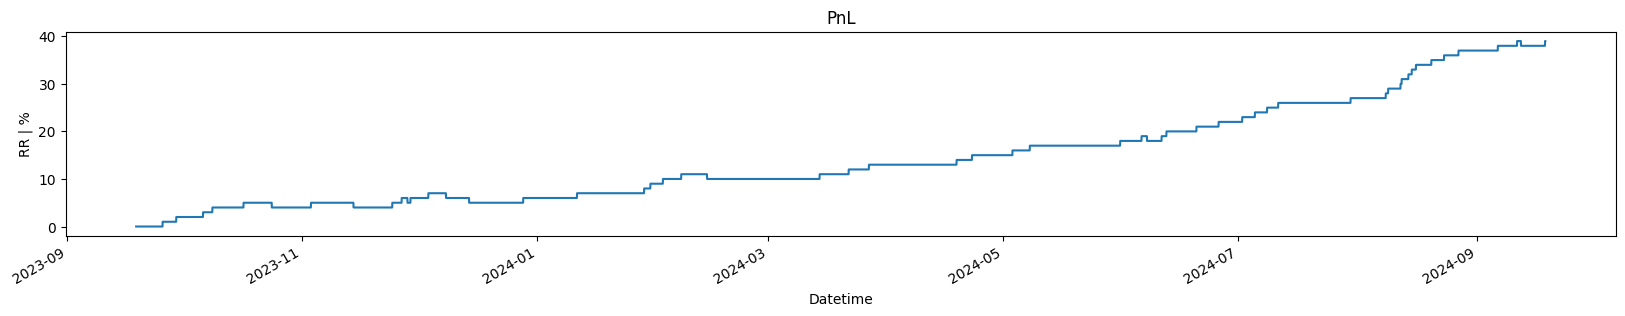

In [157]:
df.set_index('Datetime', inplace=True)

df['Cumulative_PnL'].plot(
    kind='line', 
    figsize=(20, 3), 
    title="PnL",
    ylabel="RR | %",
)

- **Drawdown**

<Axes: title={'center': 'Drawdown'}, xlabel='Datetime', ylabel='RR | %'>

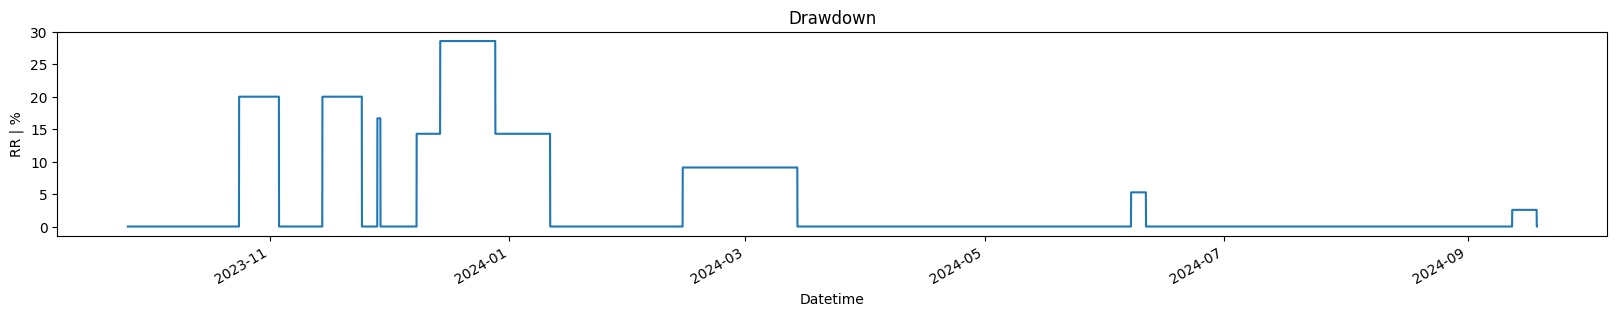

In [158]:
df['Peak'] = df['Cumulative_PnL'].cummax()

df['Drawdown'] = 100 * (df['Peak'] - df['Cumulative_PnL']) / df['Peak']

df['Drawdown'].plot(
    kind='line', 
    figsize=(20, 3), 
    title="Drawdown",
    ylabel="RR | %",
)

In [159]:
print(f"Max drawdown is {round(df['Drawdown'].max(), 2)} %")

Max drawdown is 28.57 %
